
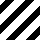
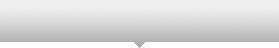
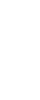
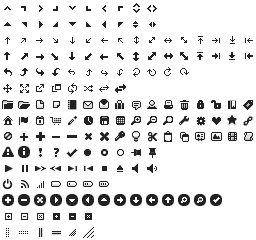
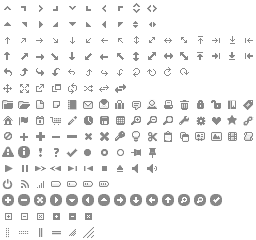
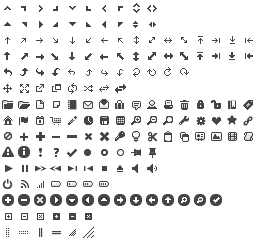
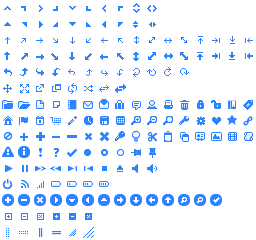
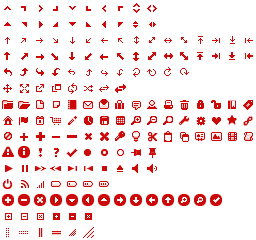
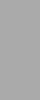
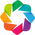
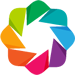
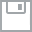
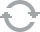
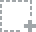
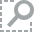
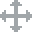
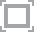
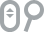

In [24]:
from scipy import io
import numpy as np
from scipy import stats
import sys
import os
from nitime.algorithms import dpss_windows
import glob
import bokeh.plotting as bplot
import bokeh.palettes as colorpalettes
bplot.output_notebook()

import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = [15,15]

Create some functions to load and store data in dictionaries:

In [6]:
def get_file_list(dataDir, probeFreqs, elicitorTypes):
    fileDict = {}
    freqs = []

    if isinstance(probeFreqs, int):
        freqs.append(str(probeFreqs) + 'Hz')
    else:
        for f in probeFreqs:
            freqs.append(str(int(f)) + 'Hz')
            
    for pf in freqs:
        fileDict[pf] = {}
        for el in elicitorTypes:
            fileDict[pf][el] = []
            assert(pf[-2:] == 'Hz')
            searchStr = os.path.join(dataDir, '[0-9]*_[0-9]*_*dB' +
                                              pf + '*_' + el + '.mat')
            fileList = glob.glob(searchStr)
            for f in fileList:
                fn = os.path.split(f)[-1]
                fnParts = fn.split('_')[2:]
                if fnParts[0].split('dB')[1] == pf:
                    fileDict[pf][el].append(f)

    return fileDict

def retrieve_data(fileDict, keepDur, findStart=True):
    sampleRate = None
    accelerometer = {}
    acoustic = {}
    pCanal = {}
    probeTimer = {}
    elicitorTimer = {}

    for pf in fileDict.keys():
        accelerometer[pf] = {}
        acoustic[pf] = {}
        pCanal[pf] = {}
        probeTimer[pf] = {}
        elicitorTimer[pf] = {}

        for el in fileDict[pf].keys():
            accelerometer[pf][el] = []
            acoustic[pf][el] = []
            pCanal[pf][el] = []
            probeTimer[pf][el] = []
            elicitorTimer[pf][el] = []

            for fn in fileDict[pf][el]:
                tempData = io.loadmat(fn, squeeze_me=True)
                if sampleRate is not None:
                    assert tempData['Fs'] == sampleRate
                else:
                    sampleRate = float(tempData['Fs'])
                
                assert float(pf.split('Hz')[0]) == tempData['fProbe']
                
                if findStart:
                    ss, es = find_start(tempData['recBuffer'][:, 3], keepDur, sampleRate)
                else:
                    ss = 0
                    es = tempData['recBuffer'][:,3].shape[0]

                accelerometer[pf][el].append(tempData['recBuffer'][ss:es, 0])
                acoustic[pf][el].append(tempData['recBuffer'][ss:es, 1])
                pCanal[pf][el].append(tempData['recBuffer'][ss:es, 2])
                probeTimer[pf][el].append(tempData['recBuffer'][ss:es, 3])
                elicitorTimer[pf][el].append(tempData['recBuffer'][ss:es, 4])

    for pf in accelerometer.keys():
        for el in accelerometer[pf].keys():
            accelerometer[pf][el] = np.array(accelerometer[pf][el])
            acoustic[pf][el] = np.array(acoustic[pf][el])
            pCanal[pf][el] = np.array(pCanal[pf][el])
            probeTimer[pf][el] = np.array(probeTimer[pf][el])
            elicitorTimer[pf][el] = np.array(elicitorTimer[pf][el])
            
    timeAxis = np.arange(0, (es-ss)/float(sampleRate), 1/float(sampleRate))

    return sampleRate, timeAxis, accelerometer, acoustic, pCanal, probeTimer, elicitorTimer


def find_start(probeTimer, keepDur, sampleRate):
    '''
    find the first sample in the probe; this is t=0
    '''
    rectData = np.abs(probeTimer)
    maxVal = np.max(rectData)

    startSamp = np.where(rectData > 0.0005*maxVal)[0][0] - 100
    endSamp = startSamp + int(np.ceil(float(keepDur)*sampleRate)) + 100

    if endSamp > probeTimer.shape[0]:
        endSamp = probeTimer.shape[0]
        
    return startSamp, endSamp

Make a function to get the magnitude and phase change for a given probe frequency.

In [7]:
def get_pcanal_response(pCanalDict, sampleRate, elicitorStart, calcType='average'):
    
    windowSamps = 4096

    tWin = np.linspace(0, windowSamps/float(sampleRate), windowSamps, endpoint=False)
    dpssWin = dpss_windows(tWin.shape[0], 1, 1)[0].squeeze()
    
    nfft = windowSamps
    f = np.linspace(0, float(sampleRate)/2., nfft/2+1)
    
    jumpSamps = int(np.ceil(0.0025 * sampleRate))

    pMEM = {}
    
    for pp in pCanalDict.keys():
        pMEM[pp] = {}
        probeFreq = float(pp.split('Hz')[0])

        for el in pCanalDict[pp].keys():
            if calcType.lower() == 'average':
                p0 = np.atleast_2d(stats.trim_mean(pCanalDict[pp][el], 0.2, 0))
            elif calcType.lower() == 'singletrials':
                p0 = pCanalDict[pp][el]
            
            starts = np.arange(0, p0.shape[1], jumpSamps)
            ends = starts + tWin.shape[0]
            keep = ends < p0.shape[1]
            starts = starts[keep]
            ends = ends[keep]
            
            pMEM[pp][el] = {}
            
            pMEM[pp][el]['result'] = np.zeros((p0.shape[0], starts.shape[0]), dtype=complex)

            for k in range(pMEM[pp][el]['result'].shape[0]):
                for c in range(len(starts)):
                    X = np.fft.rfft(p0[k, starts[c]:ends[c]]*dpssWin, nfft)
                    fBin = np.argmin(np.abs(f - probeFreq))
                    pMEM[pp][el]['result'][k, c] = X[fBin]
            
            tMEM = starts / sampleRate
            pMEM[pp][el]['result'] *= np.atleast_2d(np.exp(-1j*2*np.pi*tMEM*probeFreq))
            pMEM[pp][el]['timeAxis'] = tMEM
            pMEM
            
    return pMEM

Now make a function to generate the plots for a given probe frequency. Note: this assumes that all probes are at the same level.

In [21]:
def plot_responses(resultDict, probeFreqs, elicitors, elicitorStartTime, elicitorEndTime, baselineTime = 0.250, unwrap=False):
    # assign colors
    colorPalette = {}
    c = 0
    for el in elicitors:
        colorPalette[el] = colorpalettes.Spectral11[c]
        c+=1
        if c == 5:
            c = 6
        if c == 11:
            c = 0
    
    magFigs = []
    phaseFigs = []
    for pp in probeFreqs:
        magFigs.append(bplot.figure(title=pp + ' magnitude',
                                    x_range=[elicitorStartTime, 
                                             elicitorEndTime+0.1],
                                    background_fill='whitesmoke'))
        phaseFigs.append(bplot.figure(title=pp + ' phase',
                                      x_range=[elicitorStartTime, 
                                               elicitorEndTime+0.1],
                                      background_fill='whitesmoke'))        
        for el in elicitors: 
            for k in range(resultDict[pp][el]['result'].shape[0]):
                if resultDict[pp][el]['result'].shape[0] == 1:
                    labStr = el
                else:
                    labStr = ' '.join(el, str(k))
                t = resultDict[pp][el]['timeAxis']
                res = resultDict[pp][el]['result'][k,:]
                baseline = np.mean(res[np.logical_and(t > (elicitorStartTime-baselineTime), 
                                                      t < elicitorStartTime)])
                res -= baseline                   
                magFigs[-1].line(t, np.abs(res), 
                                 color=colorPalette[el], 
                                 legend=(labStr),
                                 line_width=2)
                if unwrap:
                    toPlot = np.unwrap(np.angle(res))
                else:
                    toPlot = np.angle(res)
                phaseFigs[-1].line(t, toPlot,
                                   color=colorPalette[el],
                                   legend=(labStr),
                                   line_width=2)
                
        magFigs[-1].xgrid.bounds = (elicitorStartTime, elicitorEndTime)
        phaseFigs[-1].xgrid.bounds = (elicitorStartTime, elicitorEndTime)

    toShow = bplot.gridplot([magFigs, phaseFigs])
    bplot.show(toShow)

### 75 dB probe, 1 s filtered GWN elicitor (500-3500 Hz) starting at 1.5 s (4.0 s total)

In [26]:
fileDict = get_file_list('/mnt/disk2/data/memr/lv_6/', [200, 225], ['gwnFilt75dB', 'gwnFilt80dB', 'gwnFilt85dB', 'gwnFilt90dB', 'gwnFilt95dB','gwnFilt100dB'])
sampleRate, _, _, _, pCanal, probeTimer, elicitorTimer = retrieve_data(fileDict, 4.0)
pMEM = get_pcanal_response(pCanal, sampleRate, 'average')
plot_responses(pMEM, ['200Hz','225Hz'], ['gwnFilt75dB', 'gwnFilt80dB', 'gwnFilt85dB',
                                         'gwnFilt90dB', 'gwnFilt95dB', 'gwnFilt100dB'], 1.5, 2.5, unwrap=False)

### 60 dB probe level, 1 s filtered GWN (500-3500 Hz) starting at 1.0 s, 3.0 s total

In [27]:
fileDict = get_file_list('/mnt/disk2/data/memr/lv_7/', [225], ['gwnFilt75dB', 'gwnFilt80dB', 'gwnFilt85dB', 'gwnFilt90dB', 'gwnFilt95dB'])
sampleRate, _, _, _, pCanal, probeTimer, elicitorTimer = retrieve_data(fileDict, 3.0)
pMEM = get_pcanal_response(pCanal, sampleRate, 'average')
plot_responses(pMEM, ['225Hz'], ['gwnFilt75dB', 'gwnFilt80dB', 'gwnFilt85dB',
                                         'gwnFilt90dB', 'gwnFilt95dB'], 1.0, 2.0, unwrap=False)

### 70 dB probe level, 1 s filtered GWN (500-3500 Hz) starting at 1.0 s, 3.0 s total

In [28]:
fileDict = get_file_list('/mnt/disk2/data/memr/lv_9/', [225], ['gwnFilt75dB', 'gwnFilt80dB', 'gwnFilt85dB', 'gwnFilt90dB', 'gwnFilt95dB'])
sampleRate, _, _, _, pCanal, probeTimer, elicitorTimer = retrieve_data(fileDict, 3.0)
pMEM = get_pcanal_response(pCanal, sampleRate, 'average')
plot_responses(pMEM, ['225Hz'], ['gwnFilt75dB', 'gwnFilt80dB', 'gwnFilt85dB',
                                 'gwnFilt90dB', 'gwnFilt95dB'], 1.0, 2.0, unwrap=False)

### Check timeseries without a probe tone in place

There doesn't seem to be an obvious, reliable cross-talk detectable in the mic signal when the contralateral elicitor is presented at a high level. Output below.

In [12]:
fileDict = get_file_list('/mnt/disk2/data/memr/lv_8/', [225], ['gwnFilt90dB', 'gwnFilt95dB'])
sampleRate, timeAxis, _, _, pCanal, probeTimer, elicitorTimer = retrieve_data(fileDict, 3.0, findStart=False)

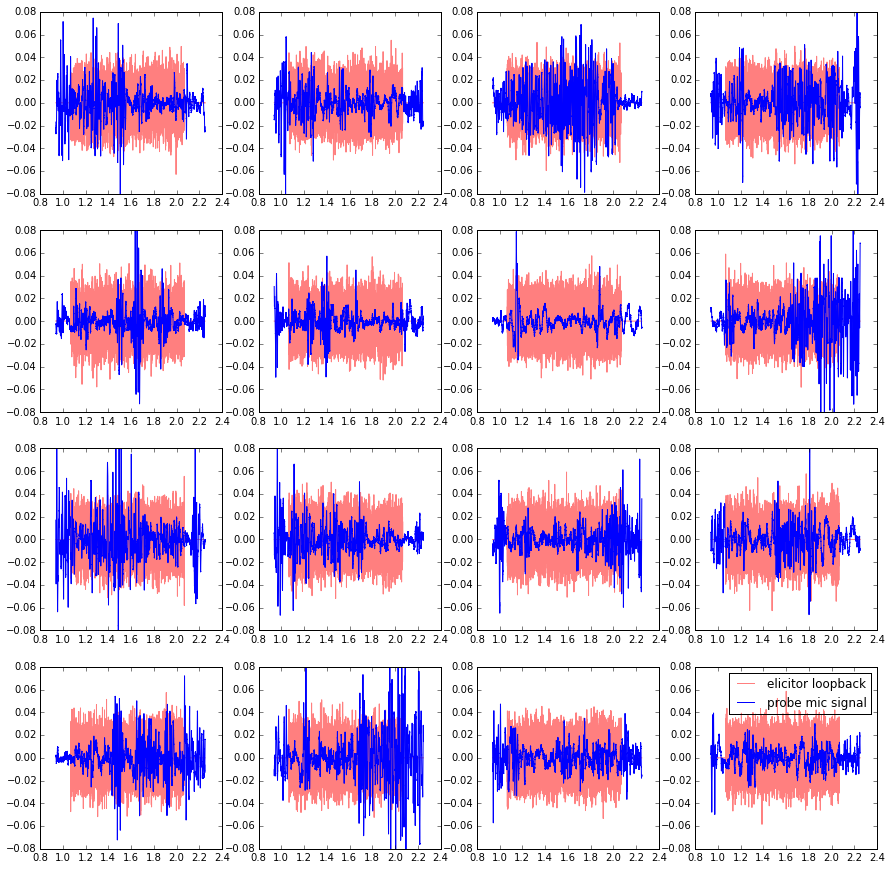

In [14]:
plt.figure()
for k in range(pCanal['225Hz']['gwnFilt95dB'].shape[0]):
    plt.subplot(4,4,k+1)
    plt.plot(timeAxis[45000:108000], elicitorTimer['225Hz']['gwnFilt95dB'][k,45000:108000], color='red', alpha=0.5, label='elicitor loopback')
    plt.plot(timeAxis[45000:108000], pCanal['225Hz']['gwnFilt95dB'][k,45000:108000], color='blue', label='probe mic signal')
    plt.ylim(-0.08, 0.08)
    
plt.legend()
plt.show()

Check the frequency distribution of the elicitor against noise against the probe:

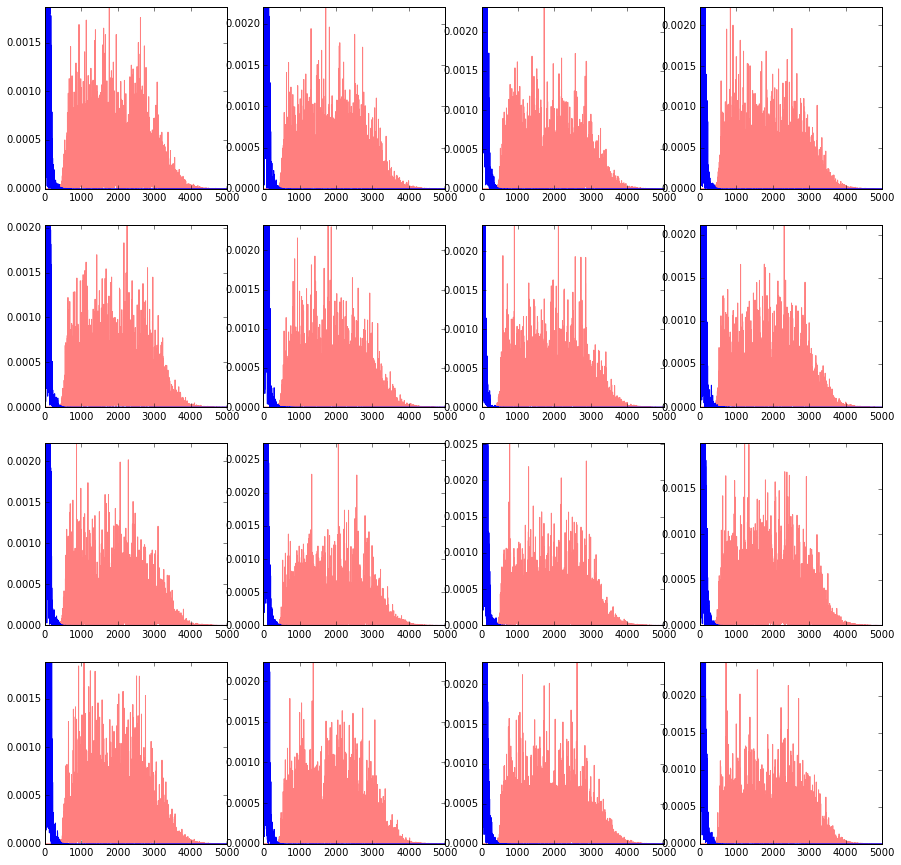

In [16]:
nfft = int(2**np.ceil(np.log2(108000-45000)))
f = np.linspace(0, 24000, nfft/2+1)

for k in range(pCanal['225Hz']['gwnFilt95dB'].shape[0]):
    plt.subplot(4,4,k+1)
    X1 = np.fft.rfft(elicitorTimer['225Hz']['gwnFilt95dB'][k,45000:108000], nfft)
    X2 = np.fft.rfft(pCanal['225Hz']['gwnFilt95dB'][k,45000:108000], nfft)

    plt.plot(f, np.abs(X1)**2.0 / sum(np.abs(X1)**2.0), color='red', alpha=0.5, label='elicitor loopback')
    plt.plot(f, np.abs(X2)**2.0 / sum(np.abs(X2)**2.0), color='blue', label='probe mic signal')
    plt.xlim(0, 5000)
    plt.ylim(0, max(np.abs(X1)**2.0 / sum(np.abs(X1)**2.0)))

plt.show()

Compare the frequency content before/during the elicitor; there doesn't look to be anything systematic going on.

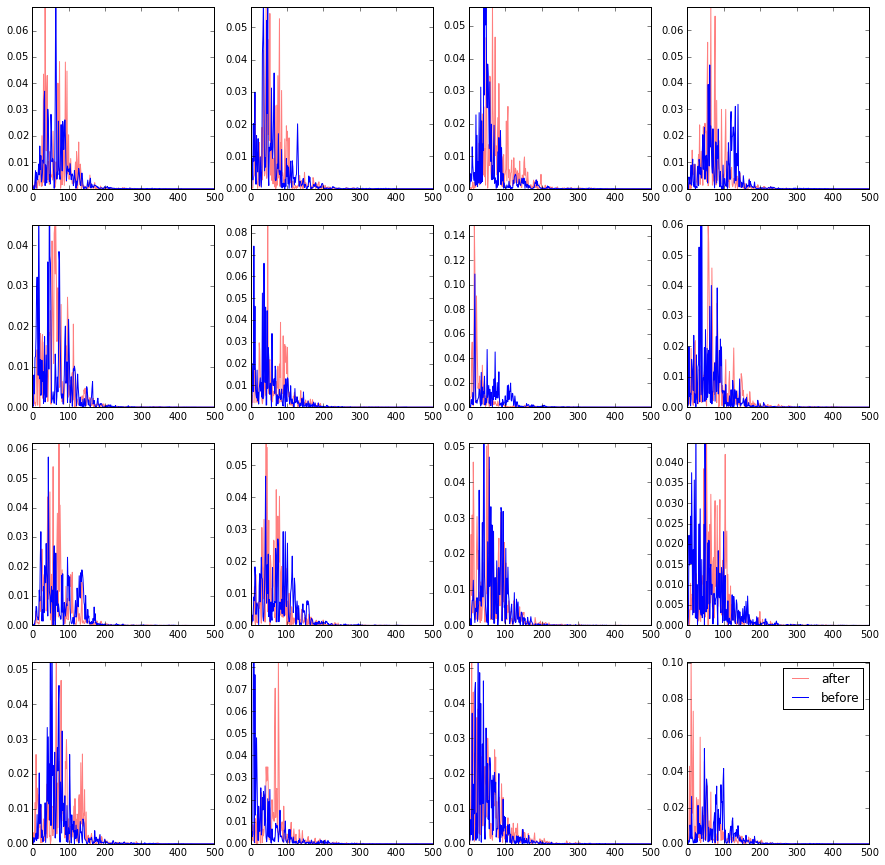

In [17]:
nfft = 2**15
f = np.linspace(0, 24000, nfft/2+1)

for k in range(pCanal['225Hz']['gwnFilt95dB'].shape[0]):
    plt.subplot(4,4,k+1)
    X1 = np.fft.rfft(pCanal['225Hz']['gwnFilt95dB'][k,57600:57600+nfft], nfft)
    X2 = np.fft.rfft(pCanal['225Hz']['gwnFilt95dB'][k,0:nfft], nfft)

    plt.plot(f, np.abs(X1)**2.0 / sum(np.abs(X1)**2.0), color='red', alpha=0.5, label='after')
    plt.plot(f, np.abs(X2)**2.0 / sum(np.abs(X2)**2.0), color='blue', label='before')
    plt.xlim(0, 500)
    plt.ylim(0, max(np.abs(X1)**2.0 / sum(np.abs(X1)**2.0)))

plt.legend()
plt.show()